In [1]:
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab.rendering import ObservationToFeatureArray

import numpy as np
import pycolab

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

# Implementations

### Environments

#### 1. Blocking Maze

In [2]:
GOAL_LOCATION = (1, 9)
GAME_ART = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '######### #',
            '#         #',
            '#   P     #',
            '###########']

GAME_4RT = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '# #########',
            '#         #',
            '#   P     #',
            '###########']


def make_game(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite})


class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.
    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location, the agent receives a reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')
    


    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things   # Unused in this application.

        # Apply motion commands.
        if actions == 0:    # walk upward?
            self._north(board, the_plot)
            #print('Walks up')
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
            #print('Walks down')
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
            #print('Walks left')
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)
            #print('Walks right')

        # See if we've found the mystery spot.
        if self.position == GOAL_LOCATION:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0.0)            

In [3]:
def show_board(obs):
    
    board = 80 * np.array(obs.layers['P'], dtype=np.float)
    board += 15 * np.array(obs.layers['#'], dtype=np.float)
    
    goal_mask = np.zeros(shape=board.shape)
    goal_mask[GOAL_LOCATION] = 1
    board += 70 * goal_mask

    plt.figure(figsize=(4, 2))
    plt.imshow(board)
    plt.axis('off')
    plt.show()

In [4]:
class Board(object):
    def __init__(self):
        #
        self.fig, self.ax = plt.subplots(1, 1, figsize=(4, 2))
        self.ax.axis("off")
        
        #
        self.i = 0
        self.p = None
        
    def show(self, obs):

        _board = 10 * np.array(obs.layers['P'], dtype=np.float)
        _board += 2 * np.array(obs.layers['#'], dtype=np.float)

        goal_mask = np.zeros(shape=_board.shape)
        goal_mask[GOAL_LOCATION] = 1
        _board += 7 * goal_mask
        
        if self.i == 0:
            self.p = self.ax.imshow(_board)
        else:
            self.p.set_data(_board)
        
        self.i += 1
        
        plt.axis('off')
        plt.pause(0.1)

In [5]:
def init_art(art, position):
    y, x = position
    tmp = list(art[y])
    tmp[x] = "P"
    art[y] = "".join(tmp)

In [ ]:
MAZE_ART = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '######### #',
            '#         #',
            '#         #',
            '###########']

MAZE_4RT = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '# #########',
            '#         #',
            '#         #',
            '###########']

#
board = Board()

# Instanciates our game object
init_art(MAZE_ART, (6, 4))
game = make_game(MAZE_ART)
steps = 0

# Finalize the engine. Set-up and compute the first observation of the game
obs, reward, gamma = game.its_showtime()
show_board(obs)

# Take actions at random until termination
while not(game.game_over) and steps < 10:
    a = np.random.randint(4)
    obs, reward, gamma = game.play(a)
    show_board(obs)
    steps += 1
print("Changing Maze")

position = np.array(obs.layers['P'])
position = np.unravel_index(position.argmax(), position.shape)
init_art(MAZE_4RT, position)
game2 = make_game(MAZE_4RT)

obs, reward, gamma = game2.its_showtime()
show_board(obs)

while not(game2.game_over):
    a = np.random.randint(4)
    obs, reward, gamma = game2.play(a)
    show_board(obs)
    steps += 1
print('GAME OVER')

#### 2. Shortcut Maze

### Dyna-Q Algorithm

In [6]:
class SimpleModel(object):
    def __init__(self):
        self._mapping = dict()
    
    def feed(self, state, action, next_state, reward):
        if tuple(state) not in self._mapping.keys():
            self._mapping[tuple(state)] = dict()
        self._mapping[tuple(state)][action] = (reward, list(next_state))
    
    def sample(self):
        #
        state_index = np.random.choice(range(0, len(self._mapping.keys())))
        state = list(self._mapping)[state_index]
        #
        action_index = np.random.choice(range(0, len(self._mapping[state].keys())))
        action = list(self._mapping[state])[action_index]
        reward, next_state = self._mapping[state][action]
        return list(state), action, reward, list(next_state)

In [7]:
class DynaQ(object):
    def __init__(self, gamma=0.95, epsilon=0.1, alpha=0.1, n_planning_steps=5):
        # discount factor
        self.gamma = gamma

        # probability for exploration
        self.epsilon = epsilon

        # step size
        self.alpha = alpha

        # n-step planning
        self.n_planning_steps = n_planning_steps
        
    # action selection with epsilon-greedy scheme
    def _select_action(self, state, state_action_values):
        if np.random.binomial(1, self.epsilon) == 1:
            return np.random.randint(4)
        else:
            values = state_action_values[state[0], state[1], :]
            return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

    # tabular dyna-Q algorithm
    def apply(self, state_action_values, model, game, n_steps, display=False):
        #
        obs, reward, gamma = game.its_showtime()
        position = np.array(obs.layers['P'])
        current_state = np.unravel_index(position.argmax(), position.shape)
        
        if display:
            show_board(obs)

        steps = 0
        while not(game.game_over):
            #
            steps += 1

            # choose an action to execute
            action = self._select_action(current_state, state_action_values)

            # take action
            obs, reward, gamma = game.play(action)
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            if display:
                show_board(obs)

            # Q-Learning update
            state_action_values[current_state[0], current_state[1], action] += \
                self.alpha * (reward + self.gamma * np.max(state_action_values[next_state[0], next_state[1], :]) -
                state_action_values[current_state[0], current_state[1], action])

            # feed the model with experience
            model.feed(current_state, action, next_state, reward)

            # sample experience from the model
            for t in range(0, self.n_planning_steps):
                sample_state, sample_action, sample_reward, sample_next_state = model.sample()
                state_action_values[sample_state[0], sample_state[1], sample_action] += \
                    self.alpha * (sample_reward + self.gamma * np.max(state_action_values[sample_next_state[0], sample_next_state[1], :]) -
                    state_action_values[sample_state[0], sample_state[1], sample_action])

            current_state = next_state
            
            if (steps > n_steps):
                break
        print(game.game_over, steps)
        return steps

In [ ]:
MAZE_ART = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '######### #',
            '#         #',
            '#         #',
            '###########']

# instantiate game
init_art(MAZE_ART, (6, 4))
game = make_game(MAZE_ART)

# initialize state action values
state_action_values = np.zeros((game.rows, game.cols, 4))

# instantiate simple model
model = SimpleModel()

# instantiate dyna-Q algorithm
algorithm = DynaQ()

# apply algorithm
algorithm.apply(state_action_values, model, game, np.inf)

print('GAME OVER')

In [8]:
class Maze(object):
    def __init__(self, arts, start, goal):
        self.arts = arts
        self.index = 0
        
        self.START = start
        self.GOAL  = goal
        
        self._showtime = False
    
    def build(self):
        art = self.arts[self.index]
        init_art(art, self.START)
        self.game = make_game(art)
        return self
    
    def change(self):
        if self.index == len(self.arts)-1:
            self.index = 0
        else:
            self.index += 1
            
        art = self.arts[self.index]        
        init_art(art, self.START)
        self.game = make_game(art)
        return self
    
    def its_showtime(self):
        if self._showtime:
            self.build()
            self._showtime = False
        obs, reward, gamma = self.game.its_showtime()
        self._showtime = True
        return obs, reward, gamma
    
    @property
    def rows(self):
        return self.game.rows
    
    @property
    def cols(self):
        return self.game.cols
    
    @property
    def game_over(self):
        return self.game.game_over
    
    def play(self, action):
        obs, reward, gamma = self.game.play(action)
        position = np.array(obs.layers['P'])
        self.state = np.unravel_index(position.argmax(), position.shape)
        return obs, reward, gamma

In [9]:
from collections import namedtuple
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points"])

In [ ]:
MAZES = [
    ['###########',
    '#         #',
    '#         #',
    '#         #',
    '######### #',
    '#         #',
    '#         #',
    '###########'],
    ['###########',
    '#         #',
    '#         #',
    '#         #',
    '# #########',
    '#         #',
    '#         #',
    '###########']
]

# instantiate game
maze = Maze(MAZES, (6, 4), (1, 9))
maze.build()

# initialize state action values
state_action_values = np.zeros((maze.rows, maze.cols, 4))

# instantiate simple model
model = SimpleModel()

# instantiate dyna-Q algorithm
algorithm = DynaQ()

# apply algorithm
algorithm.apply(state_action_values, model, maze, 100)

# change maze
maze.change()

# apply algorithm
algorithm.apply(state_action_values, model, maze, 100)

print('GAME OVER')

In [10]:
def changing_maze(mazes, params):

    # set up max steps
    n_steps = params.n_steps

    # track the cumulative rewards
    rewards = np.zeros((n_steps,))

    for run in range(0, params.n_runs):
        print('run:', run)
        
        # instantiate dyna-Q algorithm
        agent = DynaQ()
        
        # set up model
        model = SimpleModel()

        # track cumulative reward in current run
        rewards_ = np.zeros((n_steps,))
        
        # instantiate game
        maze = Maze(mazes, (6, 4), (1, 9))
        game = maze.build()
        index = 0

        # initialize state action values
        state_action_values = np.zeros((game.rows, game.cols, 4))

        steps = 0
        last_steps = steps
        while steps < n_steps:
            # play for an episode
            steps += agent.apply(state_action_values, model, game, n_steps, False)

            # update cumulative rewards
            steps_ = min(steps, n_steps - 1)
            rewards_[last_steps : steps_] = rewards_[last_steps]
            rewards_[steps_] = rewards_[last_steps] + 1
            last_steps = steps
            
            
            if index < len(params.change_points) and steps > params.change_points[index]:
                # change maze
                game = maze.change()
                index += 1
        rewards += rewards_

    # averaging over runs
    rewards /= params.n_runs

    return rewards

In [11]:
# BlockingMaze
def visualize():
    MAZES = [
        ['###########',
        '#         #',
        '#         #',
        '#         #',
        '######### #',
        '#         #',
        '#         #',
        '###########'],
        ['###########',
        '#         #',
        '#         #',
        '#         #',
        '# #########',
        '#         #',
        '#         #',
        '###########']
    ]
    
    #
    params = Params(n_steps=3000, n_runs=20, change_points=[1000, np.inf])

    # play
    rewards = changing_maze(MAZES, params)

    plt.figure(1)
    plt.plot(range(0, params.n_steps), rewards, label="Dyna-Q")
    plt.xlabel('time steps')
    plt.ylabel('cumulative reward')
    plt.legend(loc="best")

run: 0
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
False 47
False 48
False 49
False 50
False 51
False 52
False 53
False 54
False 55
False 56
False 57
False 58
False 59
False 60
False 61
False 62
False 63
False 64
False 65
False 66
False 67
False 68
False 69
False 70
False 71
False 72
False 73
False 74
False 75
False 76
False 77
False 78
False 79
False 80
False 81
False 82
False 83
False 84
False 85
False 86
False 87
False 88
False 89
False 90
False 91
False 92
False 93
False 94
False 95
False 96
False 97
False 98
False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
F

False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
True 18
True 18
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
True 16
True 16
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
True 22
True 22
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
Fal

False 789
False 790
False 791
False 792
False 793
False 794
False 795
False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805
False 806
False 807
False 808
False 809
False 810
False 811
False 812
False 813
False 814
False 815
False 816
False 817
False 818
False 819
False 820
False 821
False 822
False 823
False 824
False 825
False 826
False 827
False 828
False 829
False 830
False 831
False 832
False 833
False 834
False 835
False 836
False 837
False 838
False 839
False 840
False 841
False 842
False 843
False 844
False 845
False 846
False 847
False 848
False 849
False 850
False 851
False 852
False 853
False 854
False 855
False 856
False 857
False 858
False 859
False 860
False 861
False 862
False 863
False 864
False 865
False 866
False 867
False 868
False 869
False 870
False 871
False 872
False 873
False 874
False 875
False 876
False 877
False 878
False 879
False 880
False 881
False 882
False 883
False 884
False 885
False 886
False 887
False 888


False 1575
False 1576
False 1577
False 1578
False 1579
False 1580
False 1581
False 1582
False 1583
False 1584
False 1585
False 1586
False 1587
False 1588
False 1589
False 1590
False 1591
False 1592
False 1593
False 1594
False 1595
False 1596
False 1597
False 1598
False 1599
False 1600
False 1601
False 1602
False 1603
False 1604
False 1605
False 1606
False 1607
False 1608
False 1609
False 1610
False 1611
False 1612
False 1613
False 1614
False 1615
False 1616
False 1617
False 1618
False 1619
False 1620
False 1621
False 1622
False 1623
False 1624
False 1625
False 1626
False 1627
False 1628
False 1629
False 1630
False 1631
False 1632
False 1633
False 1634
False 1635
False 1636
False 1637
False 1638
False 1639
False 1640
False 1641
False 1642
False 1643
False 1644
False 1645
False 1646
False 1647
False 1648
False 1649
False 1650
False 1651
False 1652
False 1653
False 1654
False 1655
False 1656
False 1657
False 1658
False 1659
False 1660
False 1661
False 1662
False 1663
False 1664
False 1665

False 2326
False 2327
False 2328
False 2329
False 2330
False 2331
False 2332
False 2333
False 2334
False 2335
False 2336
False 2337
False 2338
False 2339
False 2340
False 2341
False 2342
False 2343
False 2344
False 2345
False 2346
False 2347
False 2348
False 2349
False 2350
False 2351
False 2352
False 2353
False 2354
False 2355
False 2356
False 2357
False 2358
False 2359
False 2360
False 2361
False 2362
False 2363
False 2364
False 2365
False 2366
False 2367
False 2368
False 2369
False 2370
False 2371
False 2372
False 2373
False 2374
False 2375
False 2376
False 2377
False 2378
False 2379
False 2380
False 2381
False 2382
False 2383
False 2384
False 2385
False 2386
False 2387
False 2388
False 2389
False 2390
False 2391
False 2392
False 2393
False 2394
False 2395
False 2396
False 2397
False 2398
False 2399
False 2400
False 2401
False 2402
False 2403
False 2404
False 2405
False 2406
False 2407
False 2408
False 2409
False 2410
False 2411
False 2412
False 2413
False 2414
False 2415
False 2416

False 87
False 88
False 89
False 90
False 91
False 92
False 93
False 94
False 95
False 96
False 97
False 98
False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128
False 129
False 130
False 131
False 132
False 133
False 134
False 135
False 136
False 137
False 138
False 139
False 140
False 141
False 142
False 143
False 144
False 145
False 146
False 147
False 148
False 149
False 150
False 151
False 152
False 153
False 154
False 155
False 156
False 157
False 158
False 159
False 160
False 161
False 162
False 163
False 164
False 165
False 166
False 167
False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
Fal

False 959
False 960
False 961
False 962
False 963
False 964
False 965
False 966
False 967
False 968
False 969
False 970
False 971
False 972
False 973
False 974
False 975
False 976
False 977
False 978
False 979
False 980
False 981
False 982
False 983
False 984
False 985
False 986
False 987
False 988
False 989
False 990
False 991
False 992
False 993
False 994
False 995
False 996
False 997
False 998
False 999
False 1000
False 1001
False 1002
False 1003
False 1004
False 1005
False 1006
False 1007
False 1008
False 1009
False 1010
False 1011
False 1012
False 1013
False 1014
False 1015
False 1016
False 1017
False 1018
False 1019
False 1020
False 1021
False 1022
False 1023
False 1024
False 1025
False 1026
False 1027
False 1028
False 1029
False 1030
False 1031
False 1032
False 1033
False 1034
False 1035
False 1036
False 1037
False 1038
False 1039
False 1040
False 1041
False 1042
False 1043
False 1044
False 1045
False 1046
False 1047
False 1048
False 1049
False 1050
False 1051
False 1052
False 1

False 645
False 646
False 647
False 648
False 649
False 650
False 651
False 652
False 653
False 654
False 655
False 656
False 657
False 658
False 659
False 660
False 661
False 662
False 663
False 664
False 665
False 666
False 667
False 668
False 669
False 670
False 671
False 672
False 673
False 674
False 675
False 676
False 677
False 678
False 679
False 680
False 681
False 682
False 683
False 684
False 685
False 686
False 687
False 688
False 689
False 690
False 691
False 692
False 693
False 694
False 695
False 696
False 697
False 698
False 699
False 700
False 701
False 702
False 703
False 704
False 705
False 706
False 707
False 708
False 709
False 710
False 711
False 712
False 713
False 714
False 715
False 716
False 717
False 718
False 719
False 720
False 721
False 722
False 723
False 724
False 725
False 726
False 727
False 728
False 729
False 730
False 731
False 732
False 733
False 734
False 735
False 736
False 737
False 738
False 739
False 740
False 741
False 742
False 743
False 744


False 1443
False 1444
False 1445
False 1446
False 1447
False 1448
False 1449
False 1450
False 1451
False 1452
False 1453
False 1454
False 1455
False 1456
False 1457
False 1458
False 1459
False 1460
False 1461
False 1462
False 1463
False 1464
False 1465
False 1466
False 1467
False 1468
False 1469
False 1470
False 1471
False 1472
False 1473
False 1474
False 1475
False 1476
False 1477
False 1478
False 1479
False 1480
False 1481
False 1482
False 1483
False 1484
False 1485
False 1486
False 1487
False 1488
False 1489
False 1490
False 1491
False 1492
False 1493
False 1494
False 1495
False 1496
False 1497
False 1498
False 1499
False 1500
False 1501
False 1502
False 1503
False 1504
False 1505
False 1506
False 1507
False 1508
False 1509
False 1510
False 1511
False 1512
False 1513
False 1514
False 1515
False 1516
False 1517
False 1518
False 1519
False 1520
False 1521
False 1522
False 1523
False 1524
False 1525
False 1526
False 1527
False 1528
False 1529
False 1530
False 1531
False 1532
False 1533

False 2207
False 2208
False 2209
False 2210
False 2211
False 2212
False 2213
False 2214
False 2215
False 2216
False 2217
False 2218
False 2219
False 2220
False 2221
False 2222
False 2223
False 2224
False 2225
False 2226
False 2227
False 2228
False 2229
False 2230
False 2231
False 2232
False 2233
False 2234
False 2235
False 2236
False 2237
False 2238
False 2239
False 2240
False 2241
False 2242
False 2243
False 2244
False 2245
False 2246
False 2247
False 2248
False 2249
False 2250
False 2251
False 2252
False 2253
False 2254
False 2255
False 2256
False 2257
False 2258
False 2259
False 2260
False 2261
False 2262
False 2263
False 2264
False 2265
False 2266
False 2267
False 2268
False 2269
False 2270
False 2271
False 2272
False 2273
False 2274
False 2275
False 2276
False 2277
False 2278
False 2279
False 2280
False 2281
False 2282
False 2283
False 2284
False 2285
False 2286
False 2287
False 2288
False 2289
False 2290
False 2291
False 2292
False 2293
False 2294
False 2295
False 2296
False 2297

False 2973
False 2974
False 2975
False 2976
False 2977
False 2978
False 2979
False 2980
False 2981
False 2982
False 2983
False 2984
False 2985
False 2986
False 2987
False 2988
False 2989
False 2990
False 2991
False 2992
False 2993
False 2994
False 2995
False 2996
False 2997
False 2998
False 2999
False 3000
False 3001
False 3001
run: 2
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
False 47
False 48
False 49
False 50
False 51
False 52
True 53
True 53
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22

False 12
False 13
False 14
False 15
False 16
True 17
True 17
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
True 15
True 15
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
True 15
True 15
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
True 16
True 16
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
Fa

False 867
False 868
False 869
False 870
False 871
False 872
False 873
False 874
False 875
False 876
False 877
False 878
False 879
False 880
False 881
False 882
False 883
False 884
False 885
False 886
False 887
False 888
False 889
False 890
False 891
False 892
False 893
False 894
False 895
False 896
False 897
False 898
False 899
False 900
False 901
False 902
False 903
False 904
False 905
False 906
False 907
False 908
False 909
False 910
False 911
False 912
False 913
False 914
False 915
False 916
False 917
False 918
False 919
False 920
False 921
False 922
False 923
False 924
False 925
False 926
False 927
False 928
False 929
False 930
False 931
False 932
False 933
False 934
False 935
False 936
False 937
False 938
False 939
False 940
False 941
False 942
False 943
False 944
False 945
False 946
False 947
False 948
False 949
False 950
False 951
False 952
False 953
False 954
False 955
False 956
False 957
False 958
False 959
False 960
False 961
False 962
False 963
False 964
False 965
False 966


False 1639
False 1640
False 1641
False 1642
False 1643
False 1644
False 1645
False 1646
False 1647
False 1648
False 1649
False 1650
False 1651
False 1652
False 1653
False 1654
False 1655
False 1656
False 1657
False 1658
False 1659
False 1660
False 1661
False 1662
False 1663
False 1664
False 1665
False 1666
False 1667
False 1668
False 1669
False 1670
False 1671
False 1672
False 1673
False 1674
False 1675
False 1676
False 1677
False 1678
False 1679
False 1680
False 1681
False 1682
False 1683
False 1684
False 1685
False 1686
False 1687
False 1688
False 1689
False 1690
False 1691
False 1692
False 1693
False 1694
False 1695
False 1696
False 1697
False 1698
False 1699
False 1700
False 1701
False 1702
False 1703
False 1704
False 1705
False 1706
False 1707
False 1708
False 1709
False 1710
False 1711
False 1712
False 1713
False 1714
False 1715
False 1716
False 1717
False 1718
False 1719
False 1720
False 1721
False 1722
False 1723
False 1724
False 1725
False 1726
False 1727
False 1728
False 1729

False 2391
False 2392
False 2393
False 2394
False 2395
False 2396
False 2397
False 2398
False 2399
False 2400
False 2401
False 2402
False 2403
False 2404
False 2405
False 2406
False 2407
False 2408
False 2409
False 2410
False 2411
False 2412
False 2413
False 2414
False 2415
False 2416
False 2417
False 2418
False 2419
False 2420
False 2421
False 2422
False 2423
False 2424
False 2425
False 2426
False 2427
False 2428
False 2429
False 2430
False 2431
False 2432
False 2433
False 2434
False 2435
False 2436
False 2437
False 2438
False 2439
False 2440
False 2441
False 2442
False 2443
False 2444
False 2445
False 2446
False 2447
False 2448
False 2449
False 2450
False 2451
False 2452
False 2453
False 2454
False 2455
False 2456
False 2457
False 2458
False 2459
False 2460
False 2461
False 2462
False 2463
False 2464
False 2465
False 2466
False 2467
False 2468
False 2469
False 2470
False 2471
False 2472
False 2473
False 2474
False 2475
False 2476
False 2477
False 2478
False 2479
False 2480
False 2481

False 167
False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 193
False 194
False 195
False 196
False 197
False 198
False 199
False 200
False 201
False 202
False 203
False 204
False 205
False 206
False 207
False 208
False 209
False 210
False 211
False 212
False 213
False 214
False 215
False 216
False 217
False 218
False 219
False 220
False 221
False 222
False 223
False 224
False 225
False 226
False 227
False 228
False 229
False 230
False 231
False 232
False 233
False 234
False 235
False 236
False 237
False 238
False 239
False 240
False 241
False 242
False 243
False 244
False 245
False 246
False 247
False 248
False 249
False 250
False 251
False 252
False 253
False 254
False 255
False 256
False 257
False 258
False 259
False 260
False 261
False 262
False 263
False 264
False 265
False 266


False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128
False 129
False 130
False 131
False 132
False 133
False 134
False 135
False 136
False 137
False 138
False 139
False 140
False 141
False 142
False 143
False 144
False 145
False 146
False 147
False 148
False 149
False 150
False 151
False 152
False 153
False 154
False 155
False 156
False 157
False 158
False 159
False 160
False 161
False 162
False 163
False 164
False 165
False 166
False 167
False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 193
False 194
False 195
False 196
False 197
False 198
F

False 989
False 990
False 991
False 992
False 993
False 994
False 995
False 996
False 997
False 998
False 999
False 1000
False 1001
False 1002
False 1003
False 1004
False 1005
False 1006
False 1007
False 1008
False 1009
False 1010
False 1011
False 1012
False 1013
False 1014
False 1015
False 1016
False 1017
False 1018
False 1019
False 1020
False 1021
False 1022
False 1023
False 1024
False 1025
False 1026
False 1027
False 1028
False 1029
False 1030
False 1031
False 1032
False 1033
False 1034
False 1035
False 1036
False 1037
False 1038
False 1039
False 1040
False 1041
False 1042
False 1043
False 1044
False 1045
False 1046
False 1047
False 1048
False 1049
False 1050
False 1051
False 1052
False 1053
False 1054
False 1055
False 1056
False 1057
False 1058
False 1059
False 1060
False 1061
False 1062
False 1063
False 1064
False 1065
False 1066
False 1067
False 1068
False 1069
False 1070
False 1071
False 1072
False 1073
False 1074
False 1075
False 1076
False 1077
False 1078
False 1079
False 1080

False 1796
False 1797
False 1798
False 1799
False 1800
False 1801
False 1802
False 1803
False 1804
False 1805
False 1806
False 1807
False 1808
False 1809
False 1810
False 1811
False 1812
False 1813
False 1814
False 1815
False 1816
False 1817
False 1818
False 1819
False 1820
False 1821
False 1822
False 1823
False 1824
False 1825
False 1826
False 1827
False 1828
False 1829
False 1830
False 1831
False 1832
False 1833
False 1834
False 1835
False 1836
False 1837
False 1838
False 1839
False 1840
False 1841
False 1842
False 1843
False 1844
False 1845
False 1846
False 1847
False 1848
False 1849
False 1850
False 1851
False 1852
False 1853
False 1854
False 1855
False 1856
False 1857
False 1858
False 1859
False 1860
False 1861
False 1862
False 1863
False 1864
False 1865
False 1866
False 1867
False 1868
False 1869
False 1870
False 1871
False 1872
False 1873
False 1874
False 1875
False 1876
False 1877
False 1878
False 1879
False 1880
False 1881
False 1882
False 1883
False 1884
False 1885
False 1886

False 2589
False 2590
False 2591
False 2592
False 2593
False 2594
False 2595
False 2596
False 2597
False 2598
False 2599
False 2600
False 2601
False 2602
False 2603
False 2604
False 2605
False 2606
False 2607
False 2608
False 2609
False 2610
False 2611
False 2612
False 2613
False 2614
False 2615
False 2616
False 2617
False 2618
False 2619
False 2620
False 2621
False 2622
False 2623
False 2624
False 2625
False 2626
False 2627
False 2628
False 2629
False 2630
False 2631
False 2632
False 2633
False 2634
False 2635
False 2636
False 2637
False 2638
False 2639
False 2640
False 2641
False 2642
False 2643
False 2644
False 2645
False 2646
False 2647
False 2648
False 2649
False 2650
False 2651
False 2652
False 2653
False 2654
False 2655
False 2656
False 2657
False 2658
False 2659
False 2660
False 2661
False 2662
False 2663
False 2664
False 2665
False 2666
False 2667
False 2668
False 2669
False 2670
False 2671
False 2672
False 2673
False 2674
False 2675
False 2676
False 2677
False 2678
False 2679

False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
True 15
True 15
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 

False 338
False 339
False 340
False 341
False 342
False 343
False 344
False 345
False 346
False 347
False 348
False 349
False 350
False 351
False 352
False 353
False 354
False 355
False 356
False 357
False 358
False 359
False 360
False 361
False 362
False 363
False 364
False 365
False 366
False 367
False 368
False 369
False 370
False 371
False 372
False 373
False 374
False 375
False 376
False 377
False 378
False 379
False 380
False 381
False 382
False 383
False 384
False 385
False 386
False 387
False 388
False 389
False 390
False 391
False 392
False 393
False 394
False 395
False 396
False 397
False 398
False 399
False 400
False 401
False 402
False 403
False 404
False 405
False 406
False 407
False 408
False 409
False 410
False 411
False 412
False 413
False 414
False 415
False 416
False 417
False 418
False 419
False 420
False 421
False 422
False 423
False 424
False 425
False 426
False 427
False 428
False 429
False 430
False 431
False 432
False 433
False 434
False 435
False 436
False 437


False 1226
False 1227
False 1228
False 1229
False 1230
False 1231
False 1232
False 1233
False 1234
False 1235
False 1236
False 1237
False 1238
False 1239
False 1240
False 1241
False 1242
False 1243
False 1244
False 1245
False 1246
False 1247
False 1248
False 1249
False 1250
False 1251
False 1252
False 1253
False 1254
False 1255
False 1256
False 1257
False 1258
False 1259
False 1260
False 1261
False 1262
False 1263
False 1264
False 1265
False 1266
False 1267
False 1268
False 1269
False 1270
False 1271
False 1272
False 1273
False 1274
False 1275
False 1276
False 1277
False 1278
False 1279
False 1280
False 1281
False 1282
False 1283
False 1284
False 1285
False 1286
False 1287
False 1288
False 1289
False 1290
False 1291
False 1292
False 1293
False 1294
False 1295
False 1296
False 1297
False 1298
False 1299
False 1300
False 1301
False 1302
False 1303
False 1304
False 1305
False 1306
False 1307
False 1308
False 1309
False 1310
False 1311
False 1312
False 1313
False 1314
False 1315
False 1316

False 2006
False 2007
False 2008
False 2009
False 2010
False 2011
False 2012
False 2013
False 2014
False 2015
False 2016
False 2017
False 2018
False 2019
False 2020
False 2021
False 2022
False 2023
False 2024
False 2025
False 2026
False 2027
False 2028
False 2029
False 2030
False 2031
False 2032
False 2033
False 2034
False 2035
False 2036
False 2037
False 2038
False 2039
False 2040
False 2041
False 2042
False 2043
False 2044
False 2045
False 2046
False 2047
False 2048
False 2049
False 2050
False 2051
False 2052
False 2053
False 2054
False 2055
False 2056
False 2057
False 2058
False 2059
False 2060
False 2061
False 2062
False 2063
False 2064
False 2065
False 2066
False 2067
False 2068
False 2069
False 2070
False 2071
False 2072
False 2073
False 2074
False 2075
False 2076
False 2077
False 2078
False 2079
False 2080
False 2081
False 2082
False 2083
False 2084
False 2085
False 2086
False 2087
False 2088
False 2089
False 2090
False 2091
False 2092
False 2093
False 2094
False 2095
False 2096

False 2751
False 2752
False 2753
False 2754
False 2755
False 2756
False 2757
False 2758
False 2759
False 2760
False 2761
False 2762
False 2763
False 2764
False 2765
False 2766
False 2767
False 2768
False 2769
False 2770
False 2771
False 2772
False 2773
False 2774
False 2775
False 2776
False 2777
False 2778
False 2779
False 2780
False 2781
False 2782
False 2783
False 2784
False 2785
False 2786
False 2787
False 2788
False 2789
False 2790
False 2791
False 2792
False 2793
False 2794
False 2795
False 2796
False 2797
False 2798
False 2799
False 2800
False 2801
False 2802
False 2803
False 2804
False 2805
False 2806
False 2807
False 2808
False 2809
False 2810
False 2811
False 2812
False 2813
False 2814
False 2815
False 2816
False 2817
False 2818
False 2819
False 2820
False 2821
False 2822
False 2823
False 2824
False 2825
False 2826
False 2827
False 2828
False 2829
False 2830
False 2831
False 2832
False 2833
False 2834
False 2835
False 2836
False 2837
False 2838
False 2839
False 2840
False 2841

True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3

False 503
False 504
False 505
False 506
False 507
False 508
False 509
False 510
False 511
False 512
False 513
False 514
False 515
False 516
False 517
False 518
False 519
False 520
False 521
False 522
False 523
False 524
False 525
False 526
False 527
False 528
False 529
False 530
False 531
False 532
False 533
False 534
False 535
False 536
False 537
False 538
False 539
False 540
False 541
False 542
False 543
False 544
False 545
False 546
False 547
False 548
False 549
False 550
False 551
False 552
False 553
False 554
False 555
False 556
False 557
False 558
False 559
False 560
False 561
False 562
False 563
False 564
False 565
False 566
False 567
False 568
False 569
False 570
False 571
False 572
False 573
False 574
False 575
False 576
False 577
False 578
False 579
False 580
False 581
False 582
False 583
False 584
False 585
False 586
False 587
False 588
False 589
False 590
False 591
False 592
False 593
False 594
False 595
False 596
False 597
False 598
False 599
False 600
False 601
False 602


False 1347
False 1348
False 1349
False 1350
False 1351
False 1352
False 1353
False 1354
False 1355
False 1356
False 1357
False 1358
False 1359
False 1360
False 1361
False 1362
False 1363
False 1364
False 1365
False 1366
False 1367
False 1368
False 1369
False 1370
False 1371
False 1372
False 1373
False 1374
False 1375
False 1376
False 1377
False 1378
False 1379
False 1380
False 1381
False 1382
False 1383
False 1384
False 1385
False 1386
False 1387
False 1388
False 1389
False 1390
False 1391
False 1392
False 1393
False 1394
False 1395
False 1396
False 1397
False 1398
False 1399
False 1400
False 1401
False 1402
False 1403
False 1404
False 1405
False 1406
False 1407
False 1408
False 1409
False 1410
False 1411
False 1412
False 1413
False 1414
False 1415
False 1416
False 1417
False 1418
False 1419
False 1420
False 1421
False 1422
False 1423
False 1424
False 1425
False 1426
False 1427
False 1428
False 1429
False 1430
False 1431
False 1432
False 1433
False 1434
False 1435
False 1436
False 1437

False 2129
False 2130
False 2131
False 2132
False 2133
False 2134
False 2135
False 2136
False 2137
False 2138
False 2139
False 2140
False 2141
False 2142
False 2143
False 2144
False 2145
False 2146
False 2147
False 2148
False 2149
False 2150
False 2151
False 2152
False 2153
False 2154
False 2155
False 2156
False 2157
False 2158
False 2159
False 2160
False 2161
False 2162
False 2163
False 2164
False 2165
False 2166
False 2167
False 2168
False 2169
False 2170
False 2171
False 2172
False 2173
False 2174
False 2175
False 2176
False 2177
False 2178
False 2179
False 2180
False 2181
False 2182
False 2183
False 2184
False 2185
False 2186
False 2187
False 2188
False 2189
False 2190
False 2191
False 2192
False 2193
False 2194
False 2195
False 2196
False 2197
False 2198
False 2199
False 2200
False 2201
False 2202
False 2203
False 2204
False 2205
False 2206
False 2207
False 2208
False 2209
False 2210
False 2211
False 2212
False 2213
False 2214
False 2215
False 2216
False 2217
False 2218
False 2219

False 2941
False 2942
False 2943
False 2944
False 2945
False 2946
False 2947
False 2948
False 2949
False 2950
False 2951
False 2952
False 2953
False 2954
False 2955
False 2956
False 2957
False 2958
False 2959
False 2960
False 2961
False 2962
False 2963
False 2964
False 2965
False 2966
False 2967
False 2968
False 2969
False 2970
False 2971
False 2972
False 2973
False 2974
False 2975
False 2976
False 2977
False 2978
False 2979
False 2980
False 2981
False 2982
False 2983
False 2984
False 2985
False 2986
False 2987
False 2988
False 2989
False 2990
False 2991
False 2992
False 2993
False 2994
False 2995
False 2996
False 2997
False 2998
False 2999
False 3000
False 3001
False 3001
run: 6
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False

False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
True 15
True 15
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
True 15
True 15
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12

False 741
False 742
False 743
False 744
False 745
False 746
False 747
False 748
False 749
False 750
False 751
False 752
False 753
False 754
False 755
False 756
False 757
False 758
False 759
False 760
False 761
False 762
False 763
False 764
False 765
False 766
False 767
False 768
False 769
False 770
False 771
False 772
False 773
False 774
False 775
False 776
False 777
False 778
False 779
False 780
False 781
False 782
False 783
False 784
False 785
False 786
False 787
False 788
False 789
False 790
False 791
False 792
False 793
False 794
False 795
False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805
False 806
False 807
False 808
False 809
False 810
False 811
False 812
False 813
False 814
False 815
False 816
False 817
False 818
False 819
False 820
False 821
False 822
False 823
False 824
False 825
False 826
False 827
False 828
False 829
False 830
False 831
False 832
False 833
False 834
False 835
False 836
False 837
False 838
False 839
False 840


False 1519
False 1520
False 1521
False 1522
False 1523
False 1524
False 1525
False 1526
False 1527
False 1528
False 1529
False 1530
False 1531
False 1532
False 1533
False 1534
False 1535
False 1536
False 1537
False 1538
False 1539
False 1540
False 1541
False 1542
False 1543
False 1544
False 1545
False 1546
False 1547
False 1548
False 1549
False 1550
False 1551
False 1552
False 1553
False 1554
False 1555
False 1556
False 1557
False 1558
False 1559
False 1560
False 1561
False 1562
False 1563
False 1564
False 1565
False 1566
False 1567
False 1568
False 1569
False 1570
False 1571
False 1572
False 1573
False 1574
False 1575
False 1576
False 1577
False 1578
False 1579
False 1580
False 1581
False 1582
False 1583
False 1584
False 1585
False 1586
False 1587
False 1588
False 1589
False 1590
False 1591
False 1592
False 1593
False 1594
False 1595
False 1596
False 1597
False 1598
False 1599
False 1600
False 1601
False 1602
False 1603
False 1604
False 1605
False 1606
False 1607
False 1608
False 1609

False 2325
False 2326
False 2327
False 2328
False 2329
False 2330
False 2331
False 2332
False 2333
False 2334
False 2335
False 2336
False 2337
False 2338
False 2339
False 2340
False 2341
False 2342
False 2343
False 2344
False 2345
False 2346
False 2347
False 2348
False 2349
False 2350
False 2351
False 2352
False 2353
False 2354
False 2355
False 2356
False 2357
False 2358
False 2359
False 2360
False 2361
False 2362
False 2363
False 2364
False 2365
False 2366
False 2367
False 2368
False 2369
False 2370
False 2371
False 2372
False 2373
False 2374
False 2375
False 2376
False 2377
False 2378
False 2379
False 2380
False 2381
False 2382
False 2383
False 2384
False 2385
False 2386
False 2387
False 2388
False 2389
False 2390
False 2391
False 2392
False 2393
False 2394
False 2395
False 2396
False 2397
False 2398
False 2399
False 2400
False 2401
False 2402
False 2403
False 2404
False 2405
False 2406
False 2407
False 2408
False 2409
False 2410
False 2411
False 2412
False 2413
False 2414
False 2415

False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
True 17
True 17
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
Tru

False 708
False 709
False 710
False 711
False 712
False 713
False 714
False 715
False 716
False 717
False 718
False 719
False 720
False 721
False 722
False 723
False 724
False 725
False 726
False 727
False 728
False 729
False 730
False 731
False 732
False 733
False 734
False 735
False 736
False 737
False 738
False 739
False 740
False 741
False 742
False 743
False 744
False 745
False 746
False 747
False 748
False 749
False 750
False 751
False 752
False 753
False 754
False 755
False 756
False 757
False 758
False 759
False 760
False 761
False 762
False 763
False 764
False 765
False 766
False 767
False 768
False 769
False 770
False 771
False 772
False 773
False 774
False 775
False 776
False 777
False 778
False 779
False 780
False 781
False 782
False 783
False 784
False 785
False 786
False 787
False 788
False 789
False 790
False 791
False 792
False 793
False 794
False 795
False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805
False 806
False 807


False 1490
False 1491
False 1492
False 1493
False 1494
False 1495
False 1496
False 1497
False 1498
False 1499
False 1500
False 1501
False 1502
False 1503
False 1504
False 1505
False 1506
False 1507
False 1508
False 1509
False 1510
False 1511
False 1512
False 1513
False 1514
False 1515
False 1516
False 1517
False 1518
False 1519
False 1520
False 1521
False 1522
False 1523
False 1524
False 1525
False 1526
False 1527
False 1528
False 1529
False 1530
False 1531
False 1532
False 1533
False 1534
False 1535
False 1536
False 1537
False 1538
False 1539
False 1540
False 1541
False 1542
False 1543
False 1544
False 1545
False 1546
False 1547
False 1548
False 1549
False 1550
False 1551
False 1552
False 1553
False 1554
False 1555
False 1556
False 1557
False 1558
False 1559
False 1560
False 1561
False 1562
False 1563
False 1564
False 1565
False 1566
False 1567
False 1568
False 1569
False 1570
False 1571
False 1572
False 1573
False 1574
False 1575
False 1576
False 1577
False 1578
False 1579
False 1580

False 2240
False 2241
False 2242
False 2243
False 2244
False 2245
False 2246
False 2247
False 2248
False 2249
False 2250
False 2251
False 2252
False 2253
False 2254
False 2255
False 2256
False 2257
False 2258
False 2259
False 2260
False 2261
False 2262
False 2263
False 2264
False 2265
False 2266
False 2267
False 2268
False 2269
False 2270
False 2271
False 2272
False 2273
False 2274
False 2275
False 2276
False 2277
False 2278
False 2279
False 2280
False 2281
False 2282
False 2283
False 2284
False 2285
False 2286
False 2287
False 2288
False 2289
False 2290
False 2291
False 2292
False 2293
False 2294
False 2295
False 2296
False 2297
False 2298
False 2299
False 2300
False 2301
False 2302
False 2303
False 2304
False 2305
False 2306
False 2307
False 2308
False 2309
False 2310
False 2311
False 2312
False 2313
False 2314
False 2315
False 2316
False 2317
False 2318
False 2319
False 2320
False 2321
False 2322
False 2323
False 2324
False 2325
False 2326
False 2327
False 2328
False 2329
False 2330

False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
False 47
False 48
False 49
False 50
False 51
False 52
False 53
False 54
False 55
False 56
False 57
False 58
False 59
False 60
False 61
False 62
False 63
False 64
False 65
False 66
False 67
False 68
False 69
False 70
False 71
False 72
False 73
False 74
False 75
False 76
False 77
False 78
False 79
False 80
False 81
False 82
False 83
False 84
False 85
False 86
False 87
False 88
False 89
False 90
False 91
False 92
False 93
False 94
False 95
False 96
False 97
False 98
False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114


False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
True 16
True 16
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
True 15
True 15
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27


False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805
False 806
False 807
False 808
False 809
False 810
False 811
False 812
False 813
False 814
False 815
False 816
False 817
False 818
False 819
False 820
False 821
False 822
False 823
False 824
False 825
False 826
False 827
False 828
False 829
False 830
False 831
False 832
False 833
False 834
False 835
False 836
False 837
False 838
False 839
False 840
False 841
False 842
False 843
False 844
False 845
False 846
False 847
False 848
False 849
False 850
False 851
False 852
False 853
False 854
False 855
False 856
False 857
False 858
False 859
False 860
False 861
False 862
False 863
False 864
False 865
False 866
False 867
False 868
False 869
False 870
False 871
False 872
False 873
False 874
False 875
False 876
False 877
False 878
False 879
False 880
False 881
False 882
False 883
False 884
False 885
False 886
False 887
False 888
False 889
False 890
False 891
False 892
False 893
False 894
False 895


False 1628
False 1629
False 1630
False 1631
False 1632
False 1633
False 1634
False 1635
False 1636
False 1637
False 1638
False 1639
False 1640
False 1641
False 1642
False 1643
False 1644
False 1645
False 1646
False 1647
False 1648
False 1649
False 1650
False 1651
False 1652
False 1653
False 1654
False 1655
False 1656
False 1657
False 1658
False 1659
False 1660
False 1661
False 1662
False 1663
False 1664
False 1665
False 1666
False 1667
False 1668
False 1669
False 1670
False 1671
False 1672
False 1673
False 1674
False 1675
False 1676
False 1677
False 1678
False 1679
False 1680
False 1681
False 1682
False 1683
False 1684
False 1685
False 1686
False 1687
False 1688
False 1689
False 1690
False 1691
False 1692
False 1693
False 1694
False 1695
False 1696
False 1697
False 1698
False 1699
False 1700
False 1701
False 1702
False 1703
False 1704
False 1705
False 1706
False 1707
False 1708
False 1709
False 1710
False 1711
False 1712
False 1713
False 1714
False 1715
False 1716
False 1717
False 1718

False 2450
False 2451
False 2452
False 2453
False 2454
False 2455
False 2456
False 2457
False 2458
False 2459
False 2460
False 2461
False 2462
False 2463
False 2464
False 2465
False 2466
False 2467
False 2468
False 2469
False 2470
False 2471
False 2472
False 2473
False 2474
False 2475
False 2476
False 2477
False 2478
False 2479
False 2480
False 2481
False 2482
False 2483
False 2484
False 2485
False 2486
False 2487
False 2488
False 2489
False 2490
False 2491
False 2492
False 2493
False 2494
False 2495
False 2496
False 2497
False 2498
False 2499
False 2500
False 2501
False 2502
False 2503
False 2504
False 2505
False 2506
False 2507
False 2508
False 2509
False 2510
False 2511
False 2512
False 2513
False 2514
False 2515
False 2516
False 2517
False 2518
False 2519
False 2520
False 2521
False 2522
False 2523
False 2524
False 2525
False 2526
False 2527
False 2528
False 2529
False 2530
False 2531
False 2532
False 2533
False 2534
False 2535
False 2536
False 2537
False 2538
False 2539
False 2540

False 328
False 329
False 330
False 331
False 332
False 333
False 334
False 335
False 336
False 337
False 338
False 339
False 340
False 341
False 342
False 343
False 344
False 345
False 346
False 347
False 348
False 349
False 350
False 351
False 352
False 353
False 354
False 355
False 356
False 357
False 358
False 359
False 360
False 361
False 362
False 363
False 364
False 365
False 366
False 367
False 368
False 369
False 370
False 371
False 372
False 373
False 374
False 375
False 376
False 377
False 378
False 379
False 380
False 381
False 382
False 383
False 384
False 385
False 386
False 387
False 388
False 389
False 390
False 391
False 392
False 393
False 394
False 395
False 396
False 397
False 398
False 399
False 400
False 401
False 402
False 403
False 404
False 405
False 406
False 407
False 408
False 409
False 410
False 411
False 412
False 413
False 414
False 415
False 416
False 417
False 418
False 419
False 420
False 421
False 422
False 423
False 424
False 425
False 426
False 427


False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 193
False 194
False 195
False 196
False 197
False 198
False 199
False 200
False 201
False 202
False 203
False 204
False 205
False 206
False 207
False 208
False 209
False 210
False 211
False 212
False 213
False 214
False 215
False 216
False 217
False 218
False 219
False 220
False 221
False 222
False 223
False 224
False 225
False 226
False 227
False 228
False 229
False 230
False 231
False 232
False 233
False 234
False 235
False 236
False 237
False 238
False 239
False 240
False 241
False 242
False 243
False 244
False 245
False 246
False 247
False 248
False 249
False 250
False 251
False 252
False 253
False 254
False 255
False 256
False 257
False 258
False 259
False 260
False 261
False 262
False 263
False 264
False 265
False 266
False 267
False 268
False 269
False 270
False 271
False 272
False 273
False 274
False 275
False 276
False 277
False 278


False 1021
False 1022
False 1023
False 1024
False 1025
False 1026
False 1027
False 1028
False 1029
False 1030
False 1031
False 1032
False 1033
False 1034
False 1035
False 1036
False 1037
False 1038
False 1039
False 1040
False 1041
False 1042
False 1043
False 1044
False 1045
False 1046
False 1047
False 1048
False 1049
False 1050
False 1051
False 1052
False 1053
False 1054
False 1055
False 1056
False 1057
False 1058
False 1059
False 1060
False 1061
False 1062
False 1063
False 1064
False 1065
False 1066
False 1067
False 1068
False 1069
False 1070
False 1071
False 1072
False 1073
False 1074
False 1075
False 1076
False 1077
False 1078
False 1079
False 1080
False 1081
False 1082
False 1083
False 1084
False 1085
False 1086
False 1087
False 1088
False 1089
False 1090
False 1091
False 1092
False 1093
False 1094
False 1095
False 1096
False 1097
False 1098
False 1099
False 1100
False 1101
False 1102
False 1103
False 1104
False 1105
False 1106
False 1107
False 1108
False 1109
False 1110
False 1111

False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
True 16
True 16
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
True 16
True 16
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
True 22
True 22
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
True 18
True 18
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
True 18
True 18
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
True 18
True 18
run: 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8


False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
Fals

False 749
False 750
False 751
False 752
False 753
False 754
False 755
False 756
False 757
False 758
False 759
False 760
False 761
False 762
False 763
False 764
False 765
False 766
False 767
False 768
False 769
False 770
False 771
False 772
False 773
False 774
False 775
False 776
False 777
False 778
False 779
False 780
False 781
False 782
False 783
False 784
False 785
False 786
False 787
False 788
False 789
False 790
False 791
False 792
False 793
False 794
False 795
False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805
False 806
False 807
False 808
False 809
False 810
False 811
False 812
False 813
False 814
False 815
False 816
False 817
False 818
False 819
False 820
False 821
False 822
False 823
False 824
False 825
False 826
False 827
False 828
False 829
False 830
False 831
False 832
False 833
False 834
False 835
False 836
False 837
False 838
False 839
False 840
False 841
False 842
False 843
False 844
False 845
False 846
False 847
False 848


False 1565
False 1566
False 1567
False 1568
False 1569
False 1570
False 1571
False 1572
False 1573
False 1574
False 1575
False 1576
False 1577
False 1578
False 1579
False 1580
False 1581
False 1582
False 1583
False 1584
False 1585
False 1586
False 1587
False 1588
False 1589
False 1590
False 1591
False 1592
False 1593
False 1594
False 1595
False 1596
False 1597
False 1598
False 1599
False 1600
False 1601
False 1602
False 1603
False 1604
False 1605
False 1606
False 1607
False 1608
False 1609
False 1610
False 1611
False 1612
False 1613
False 1614
False 1615
False 1616
False 1617
False 1618
False 1619
False 1620
False 1621
False 1622
False 1623
False 1624
False 1625
False 1626
False 1627
False 1628
False 1629
False 1630
False 1631
False 1632
False 1633
False 1634
False 1635
False 1636
False 1637
False 1638
False 1639
False 1640
False 1641
False 1642
False 1643
False 1644
False 1645
False 1646
False 1647
False 1648
False 1649
False 1650
False 1651
False 1652
False 1653
False 1654
False 1655

False 55
False 56
False 57
False 58
False 59
False 60
False 61
False 62
False 63
False 64
False 65
False 66
False 67
False 68
False 69
False 70
False 71
False 72
False 73
False 74
False 75
False 76
False 77
False 78
False 79
False 80
False 81
False 82
False 83
False 84
False 85
False 86
False 87
False 88
False 89
False 90
False 91
False 92
False 93
False 94
False 95
False 96
False 97
False 98
False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128
False 129
False 130
False 131
False 132
False 133
False 134
False 135
False 136
False 137
False 138
False 139
False 140
False 141
False 142
False 143
False 144
False 145
False 146
False 147
False 148
False 149
False 150
False 151
False 152
False 153
False 154
False 155
False 156
False 157
False 158
False

False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
False 47
False 48
False 49
False 50
False 51
False 52
False 53
False 54
False 55
False 56
False 57
False 58
False 59
False 60
False 61
False 62
False 63
False 64
False 65
False 66
False 67
False 68
False 69
False 70
False 71
False 72
False 73
False 74
False 75
False 76
False 77
False 78
False 79
False 80
False 81
False 82
False 83
False 84
False 85
False 86
False 87
False 88
False 89
False 90
False 91
False 92
False 93
False 94
False 95
False 96
False 97
False 98
False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128

False 900
False 901
False 902
False 903
False 904
False 905
False 906
False 907
False 908
False 909
False 910
False 911
False 912
False 913
False 914
False 915
False 916
False 917
False 918
False 919
False 920
False 921
False 922
False 923
False 924
False 925
False 926
False 927
False 928
False 929
False 930
False 931
False 932
False 933
False 934
False 935
False 936
False 937
False 938
False 939
False 940
False 941
False 942
False 943
False 944
False 945
False 946
False 947
False 948
False 949
False 950
False 951
False 952
False 953
False 954
False 955
False 956
False 957
False 958
False 959
False 960
False 961
False 962
False 963
False 964
False 965
False 966
False 967
False 968
False 969
False 970
False 971
False 972
False 973
False 974
False 975
False 976
False 977
False 978
False 979
False 980
False 981
False 982
False 983
False 984
False 985
False 986
False 987
False 988
False 989
False 990
False 991
False 992
False 993
False 994
False 995
False 996
False 997
False 998
False 999


False 1686
False 1687
False 1688
False 1689
False 1690
False 1691
False 1692
False 1693
False 1694
False 1695
False 1696
False 1697
False 1698
False 1699
False 1700
False 1701
False 1702
False 1703
False 1704
False 1705
False 1706
False 1707
False 1708
False 1709
False 1710
False 1711
False 1712
False 1713
False 1714
False 1715
False 1716
False 1717
False 1718
False 1719
False 1720
False 1721
False 1722
False 1723
False 1724
False 1725
False 1726
False 1727
False 1728
False 1729
False 1730
False 1731
False 1732
False 1733
False 1734
False 1735
False 1736
False 1737
False 1738
False 1739
False 1740
False 1741
False 1742
False 1743
False 1744
False 1745
False 1746
False 1747
False 1748
False 1749
False 1750
False 1751
False 1752
False 1753
False 1754
False 1755
False 1756
False 1757
False 1758
False 1759
False 1760
False 1761
False 1762
False 1763
False 1764
False 1765
False 1766
False 1767
False 1768
False 1769
False 1770
False 1771
False 1772
False 1773
False 1774
False 1775
False 1776

False 2484
False 2485
False 2486
False 2487
False 2488
False 2489
False 2490
False 2491
False 2492
False 2493
False 2494
False 2495
False 2496
False 2497
False 2498
False 2499
False 2500
False 2501
False 2502
False 2503
False 2504
False 2505
False 2506
False 2507
False 2508
False 2509
False 2510
False 2511
False 2512
False 2513
False 2514
False 2515
False 2516
False 2517
False 2518
False 2519
False 2520
False 2521
False 2522
False 2523
False 2524
False 2525
False 2526
False 2527
False 2528
False 2529
False 2530
False 2531
False 2532
False 2533
False 2534
False 2535
False 2536
False 2537
False 2538
False 2539
False 2540
False 2541
False 2542
False 2543
False 2544
False 2545
False 2546
False 2547
False 2548
False 2549
False 2550
False 2551
False 2552
False 2553
False 2554
False 2555
False 2556
False 2557
False 2558
False 2559
False 2560
False 2561
False 2562
False 2563
False 2564
False 2565
False 2566
False 2567
False 2568
False 2569
False 2570
False 2571
False 2572
False 2573
False 2574

False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
True 13
True 13
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
True 13
True 13
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
True 13
True 13
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8

False 248
False 249
False 250
False 251
False 252
False 253
False 254
False 255
False 256
False 257
False 258
False 259
False 260
False 261
False 262
False 263
False 264
False 265
False 266
False 267
False 268
False 269
False 270
False 271
False 272
False 273
False 274
False 275
False 276
False 277
False 278
False 279
False 280
False 281
False 282
False 283
False 284
False 285
False 286
False 287
False 288
False 289
False 290
False 291
False 292
False 293
False 294
False 295
False 296
False 297
False 298
False 299
False 300
False 301
False 302
False 303
False 304
False 305
False 306
False 307
False 308
False 309
False 310
False 311
False 312
False 313
False 314
False 315
False 316
False 317
False 318
False 319
False 320
False 321
False 322
False 323
False 324
False 325
False 326
False 327
False 328
False 329
False 330
False 331
False 332
False 333
False 334
False 335
False 336
False 337
False 338
False 339
False 340
False 341
False 342
False 343
False 344
False 345
False 346
False 347


False 1100
False 1101
False 1102
False 1103
False 1104
False 1105
False 1106
False 1107
False 1108
False 1109
False 1110
False 1111
False 1112
False 1113
False 1114
False 1115
False 1116
False 1117
False 1118
False 1119
False 1120
False 1121
False 1122
False 1123
False 1124
False 1125
False 1126
False 1127
False 1128
False 1129
False 1130
False 1131
False 1132
False 1133
False 1134
False 1135
False 1136
False 1137
False 1138
False 1139
False 1140
False 1141
False 1142
False 1143
False 1144
False 1145
False 1146
False 1147
False 1148
False 1149
False 1150
False 1151
False 1152
False 1153
False 1154
False 1155
False 1156
False 1157
False 1158
False 1159
False 1160
False 1161
False 1162
False 1163
False 1164
False 1165
False 1166
False 1167
False 1168
False 1169
False 1170
False 1171
False 1172
False 1173
False 1174
False 1175
False 1176
False 1177
False 1178
False 1179
False 1180
False 1181
False 1182
False 1183
False 1184
False 1185
False 1186
False 1187
False 1188
False 1189
False 1190

False 1893
False 1894
False 1895
False 1896
False 1897
False 1898
False 1899
False 1900
False 1901
False 1902
False 1903
False 1904
False 1905
False 1906
False 1907
False 1908
False 1909
False 1910
False 1911
False 1912
False 1913
False 1914
False 1915
False 1916
False 1917
False 1918
False 1919
False 1920
False 1921
False 1922
False 1923
False 1924
False 1925
False 1926
False 1927
False 1928
False 1929
False 1930
False 1931
False 1932
False 1933
False 1934
False 1935
False 1936
False 1937
False 1938
False 1939
False 1940
False 1941
False 1942
False 1943
False 1944
False 1945
False 1946
False 1947
False 1948
False 1949
False 1950
False 1951
False 1952
False 1953
False 1954
False 1955
False 1956
False 1957
False 1958
False 1959
False 1960
False 1961
False 1962
False 1963
False 1964
False 1965
False 1966
False 1967
False 1968
False 1969
False 1970
False 1971
False 1972
False 1973
False 1974
False 1975
False 1976
False 1977
False 1978
False 1979
False 1980
False 1981
False 1982
False 1983

False 2645
False 2646
False 2647
False 2648
False 2649
False 2650
False 2651
False 2652
False 2653
False 2654
False 2655
False 2656
False 2657
False 2658
False 2659
False 2660
False 2661
False 2662
False 2663
False 2664
False 2665
False 2666
False 2667
False 2668
False 2669
False 2670
False 2671
False 2672
False 2673
False 2674
False 2675
False 2676
False 2677
False 2678
False 2679
False 2680
False 2681
False 2682
False 2683
False 2684
False 2685
False 2686
False 2687
False 2688
False 2689
False 2690
False 2691
False 2692
False 2693
False 2694
False 2695
False 2696
False 2697
False 2698
False 2699
False 2700
False 2701
False 2702
False 2703
False 2704
False 2705
False 2706
False 2707
False 2708
False 2709
False 2710
False 2711
False 2712
False 2713
False 2714
False 2715
False 2716
False 2717
False 2718
False 2719
False 2720
False 2721
False 2722
False 2723
False 2724
False 2725
False 2726
False 2727
False 2728
False 2729
False 2730
False 2731
False 2732
False 2733
False 2734
False 2735

False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
Fals

False 428
False 429
False 430
False 431
False 432
False 433
False 434
False 435
False 436
False 437
False 438
False 439
False 440
False 441
False 442
False 443
False 444
False 445
False 446
False 447
False 448
False 449
False 450
False 451
False 452
False 453
False 454
False 455
False 456
False 457
False 458
False 459
False 460
False 461
False 462
False 463
False 464
False 465
False 466
False 467
False 468
False 469
False 470
False 471
False 472
False 473
False 474
False 475
False 476
False 477
False 478
False 479
False 480
False 481
False 482
False 483
False 484
False 485
False 486
False 487
False 488
False 489
False 490
False 491
False 492
False 493
False 494
False 495
False 496
False 497
False 498
False 499
False 500
False 501
False 502
False 503
False 504
False 505
False 506
False 507
False 508
False 509
False 510
False 511
False 512
False 513
False 514
False 515
False 516
False 517
False 518
False 519
False 520
False 521
False 522
False 523
False 524
False 525
False 526
False 527


False 1232
False 1233
False 1234
False 1235
False 1236
False 1237
False 1238
False 1239
False 1240
False 1241
False 1242
False 1243
False 1244
False 1245
False 1246
False 1247
False 1248
False 1249
False 1250
False 1251
False 1252
False 1253
False 1254
False 1255
False 1256
False 1257
False 1258
False 1259
False 1260
False 1261
False 1262
False 1263
False 1264
False 1265
False 1266
False 1267
False 1268
False 1269
False 1270
False 1271
False 1272
False 1273
False 1274
False 1275
False 1276
False 1277
False 1278
False 1279
False 1280
False 1281
False 1282
False 1283
False 1284
False 1285
False 1286
False 1287
False 1288
False 1289
False 1290
False 1291
False 1292
False 1293
False 1294
False 1295
False 1296
False 1297
False 1298
False 1299
False 1300
False 1301
False 1302
False 1303
False 1304
False 1305
False 1306
False 1307
False 1308
False 1309
False 1310
False 1311
False 1312
False 1313
False 1314
False 1315
False 1316
False 1317
False 1318
False 1319
False 1320
False 1321
False 1322

False 2065
False 2066
False 2067
False 2068
False 2069
False 2070
False 2071
False 2072
False 2073
False 2074
False 2075
False 2076
False 2077
False 2078
False 2079
False 2080
False 2081
False 2082
False 2083
False 2084
False 2085
False 2086
False 2087
False 2088
False 2089
False 2090
False 2091
False 2092
False 2093
False 2094
False 2095
False 2096
False 2097
False 2098
False 2099
False 2100
False 2101
False 2102
False 2103
False 2104
False 2105
False 2106
False 2107
False 2108
False 2109
False 2110
False 2111
False 2112
False 2113
False 2114
False 2115
False 2116
False 2117
False 2118
False 2119
False 2120
False 2121
False 2122
False 2123
False 2124
False 2125
False 2126
False 2127
False 2128
False 2129
False 2130
False 2131
False 2132
False 2133
False 2134
False 2135
False 2136
False 2137
False 2138
False 2139
False 2140
False 2141
False 2142
False 2143
False 2144
False 2145
False 2146
False 2147
False 2148
False 2149
False 2150
False 2151
False 2152
False 2153
False 2154
False 2155

False 2873
False 2874
False 2875
False 2876
False 2877
False 2878
False 2879
False 2880
False 2881
False 2882
False 2883
False 2884
False 2885
False 2886
False 2887
False 2888
False 2889
False 2890
False 2891
False 2892
False 2893
False 2894
False 2895
False 2896
False 2897
False 2898
False 2899
False 2900
False 2901
False 2902
False 2903
False 2904
False 2905
False 2906
False 2907
False 2908
False 2909
False 2910
False 2911
False 2912
False 2913
False 2914
False 2915
False 2916
False 2917
False 2918
False 2919
False 2920
False 2921
False 2922
False 2923
False 2924
False 2925
False 2926
False 2927
False 2928
False 2929
False 2930
False 2931
False 2932
False 2933
False 2934
False 2935
False 2936
False 2937
False 2938
False 2939
False 2940
False 2941
False 2942
False 2943
False 2944
False 2945
False 2946
False 2947
False 2948
False 2949
False 2950
False 2951
False 2952
False 2953
False 2954
False 2955
False 2956
False 2957
False 2958
False 2959
False 2960
False 2961
False 2962
False 2963

False 709
False 710
False 711
False 712
False 713
False 714
False 715
False 716
False 717
False 718
False 719
False 720
False 721
False 722
False 723
False 724
False 725
False 726
False 727
False 728
False 729
False 730
False 731
False 732
False 733
False 734
False 735
False 736
False 737
False 738
False 739
False 740
False 741
False 742
False 743
False 744
False 745
False 746
False 747
False 748
False 749
False 750
False 751
False 752
False 753
False 754
False 755
False 756
False 757
False 758
False 759
False 760
False 761
False 762
False 763
False 764
False 765
False 766
False 767
False 768
False 769
False 770
False 771
False 772
False 773
False 774
False 775
False 776
False 777
False 778
False 779
False 780
False 781
False 782
False 783
False 784
False 785
False 786
False 787
False 788
False 789
False 790
False 791
False 792
False 793
False 794
False 795
False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805
False 806
False 807
False 808


False 1556
False 1557
False 1558
False 1559
False 1560
False 1561
False 1562
False 1563
False 1564
False 1565
False 1566
False 1567
False 1568
False 1569
False 1570
False 1571
False 1572
False 1573
False 1574
False 1575
False 1576
False 1577
False 1578
False 1579
False 1580
False 1581
False 1582
False 1583
True 1584
True 1584
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
False 47
False 48
False 49
False 50
False 51
False 52
False 53
False 54
False 55
False 56
False 57
False 58
False 59
False 60
False 61
False 62
False 63
False 64
False 65
False 66
False 67
False 68
False 69
False 70
False 71
False 72
False 73
False 74
False 75
False 

False 810
False 811
False 812
False 813
False 814
False 815
False 816
False 817
False 818
False 819
False 820
False 821
False 822
False 823
False 824
False 825
False 826
False 827
False 828
False 829
False 830
False 831
False 832
False 833
False 834
False 835
False 836
False 837
False 838
False 839
False 840
False 841
False 842
False 843
False 844
False 845
False 846
False 847
False 848
False 849
False 850
False 851
False 852
False 853
False 854
False 855
False 856
False 857
False 858
False 859
False 860
False 861
False 862
False 863
False 864
False 865
False 866
False 867
False 868
False 869
False 870
False 871
False 872
False 873
False 874
False 875
False 876
False 877
False 878
False 879
False 880
False 881
False 882
False 883
False 884
False 885
False 886
False 887
False 888
False 889
False 890
False 891
False 892
False 893
False 894
False 895
False 896
False 897
False 898
False 899
False 900
False 901
False 902
False 903
False 904
False 905
False 906
False 907
False 908
False 909


False 1662
False 1663
False 1664
False 1665
False 1666
False 1667
False 1668
False 1669
False 1670
False 1671
False 1672
False 1673
False 1674
False 1675
False 1676
False 1677
False 1678
False 1679
False 1680
False 1681
False 1682
False 1683
False 1684
False 1685
False 1686
False 1687
False 1688
False 1689
False 1690
False 1691
False 1692
False 1693
False 1694
False 1695
False 1696
False 1697
False 1698
False 1699
False 1700
False 1701
False 1702
False 1703
False 1704
False 1705
False 1706
False 1707
False 1708
False 1709
False 1710
False 1711
False 1712
False 1713
False 1714
False 1715
False 1716
False 1717
False 1718
False 1719
False 1720
False 1721
False 1722
False 1723
False 1724
False 1725
False 1726
False 1727
False 1728
False 1729
False 1730
False 1731
False 1732
False 1733
False 1734
False 1735
False 1736
False 1737
False 1738
False 1739
False 1740
False 1741
False 1742
False 1743
False 1744
False 1745
False 1746
False 1747
False 1748
False 1749
False 1750
False 1751
False 1752

False 2451
False 2452
False 2453
False 2454
False 2455
False 2456
False 2457
False 2458
False 2459
False 2460
False 2461
False 2462
False 2463
False 2464
False 2465
False 2466
False 2467
False 2468
False 2469
False 2470
False 2471
False 2472
False 2473
False 2474
False 2475
False 2476
False 2477
False 2478
False 2479
False 2480
False 2481
False 2482
False 2483
False 2484
False 2485
False 2486
False 2487
False 2488
False 2489
False 2490
False 2491
False 2492
False 2493
False 2494
False 2495
False 2496
False 2497
False 2498
False 2499
False 2500
False 2501
False 2502
False 2503
False 2504
False 2505
False 2506
False 2507
False 2508
False 2509
False 2510
False 2511
False 2512
False 2513
False 2514
False 2515
False 2516
False 2517
False 2518
False 2519
False 2520
False 2521
False 2522
False 2523
False 2524
False 2525
False 2526
False 2527
False 2528
False 2529
False 2530
False 2531
False 2532
False 2533
False 2534
False 2535
False 2536
False 2537
False 2538
False 2539
False 2540
False 2541

False 248
False 249
False 250
False 251
False 252
False 253
False 254
False 255
False 256
False 257
False 258
False 259
False 260
False 261
False 262
False 263
False 264
False 265
False 266
False 267
False 268
False 269
False 270
False 271
False 272
False 273
False 274
False 275
False 276
False 277
False 278
False 279
False 280
False 281
False 282
False 283
False 284
False 285
False 286
False 287
False 288
False 289
False 290
False 291
False 292
False 293
False 294
False 295
False 296
False 297
False 298
False 299
False 300
False 301
False 302
False 303
False 304
False 305
False 306
False 307
False 308
False 309
False 310
False 311
False 312
False 313
False 314
False 315
False 316
False 317
False 318
False 319
False 320
False 321
False 322
False 323
False 324
False 325
False 326
False 327
False 328
False 329
False 330
False 331
False 332
False 333
False 334
False 335
False 336
False 337
False 338
False 339
False 340
False 341
False 342
False 343
False 344
False 345
False 346
False 347


False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 193
False 194
False 195
False 196
False 197
False 198
False 199
False 200
False 201
False 202
False 203
False 204
False 205
False 206
False 207
False 208
False 209
False 210
False 211
False 212
False 213
False 214
False 215
False 216
False 217
False 218
False 219
False 220
False 221
False 222
False 223
False 224
False 225
False 226
False 227
False 228
False 229
False 230
False 231
False 232
False 233
False 234
False 235
False 236
False 237
False 238
False 239
False 240
False 241
False 242
False 243
False 244
False 245
False 246
False 247
False 248
False 249
False 250
False 251
False 252
False 253
False 254
False 255
False 256
False 257
False 258
False 259
False 260
False 261
False 262
False 263
False 264
False 265
False 266
False 267


False 1081
False 1082
False 1083
False 1084
False 1085
False 1086
False 1087
False 1088
False 1089
False 1090
False 1091
False 1092
False 1093
False 1094
False 1095
False 1096
False 1097
False 1098
False 1099
False 1100
False 1101
False 1102
False 1103
False 1104
False 1105
False 1106
False 1107
False 1108
False 1109
False 1110
False 1111
False 1112
False 1113
False 1114
False 1115
False 1116
False 1117
False 1118
False 1119
False 1120
False 1121
False 1122
False 1123
False 1124
False 1125
False 1126
False 1127
False 1128
False 1129
False 1130
False 1131
False 1132
False 1133
False 1134
False 1135
False 1136
False 1137
False 1138
False 1139
False 1140
False 1141
False 1142
False 1143
False 1144
False 1145
False 1146
False 1147
False 1148
False 1149
False 1150
False 1151
False 1152
False 1153
False 1154
False 1155
False 1156
False 1157
False 1158
False 1159
False 1160
False 1161
False 1162
False 1163
False 1164
False 1165
False 1166
False 1167
False 1168
False 1169
False 1170
False 1171

False 1870
False 1871
False 1872
False 1873
False 1874
False 1875
False 1876
False 1877
False 1878
False 1879
False 1880
False 1881
False 1882
False 1883
False 1884
False 1885
False 1886
False 1887
False 1888
False 1889
False 1890
False 1891
False 1892
False 1893
False 1894
False 1895
False 1896
False 1897
False 1898
False 1899
False 1900
False 1901
False 1902
False 1903
False 1904
False 1905
False 1906
False 1907
False 1908
False 1909
False 1910
False 1911
False 1912
False 1913
False 1914
False 1915
False 1916
False 1917
False 1918
False 1919
False 1920
False 1921
False 1922
False 1923
False 1924
False 1925
False 1926
False 1927
False 1928
False 1929
False 1930
False 1931
False 1932
False 1933
False 1934
False 1935
False 1936
False 1937
False 1938
False 1939
False 1940
False 1941
False 1942
False 1943
False 1944
False 1945
False 1946
False 1947
False 1948
False 1949
False 1950
False 1951
False 1952
False 1953
False 1954
False 1955
False 1956
False 1957
False 1958
False 1959
False 1960

False 2660
False 2661
False 2662
False 2663
False 2664
False 2665
False 2666
False 2667
False 2668
False 2669
False 2670
False 2671
False 2672
False 2673
False 2674
False 2675
False 2676
False 2677
False 2678
False 2679
False 2680
False 2681
False 2682
False 2683
False 2684
False 2685
False 2686
False 2687
False 2688
False 2689
False 2690
False 2691
False 2692
False 2693
False 2694
False 2695
False 2696
False 2697
False 2698
False 2699
False 2700
False 2701
False 2702
False 2703
False 2704
False 2705
False 2706
False 2707
False 2708
False 2709
False 2710
False 2711
False 2712
False 2713
False 2714
False 2715
False 2716
False 2717
False 2718
False 2719
False 2720
False 2721
False 2722
False 2723
False 2724
False 2725
False 2726
False 2727
False 2728
False 2729
False 2730
False 2731
False 2732
False 2733
False 2734
False 2735
False 2736
False 2737
False 2738
False 2739
False 2740
False 2741
False 2742
False 2743
False 2744
False 2745
False 2746
False 2747
False 2748
False 2749
False 2750

False 555
False 556
False 557
False 558
False 559
False 560
False 561
False 562
False 563
False 564
False 565
False 566
False 567
False 568
False 569
False 570
False 571
False 572
False 573
False 574
False 575
False 576
False 577
False 578
False 579
False 580
False 581
False 582
False 583
False 584
False 585
False 586
False 587
False 588
False 589
False 590
False 591
False 592
False 593
False 594
False 595
False 596
False 597
False 598
False 599
False 600
False 601
False 602
True 603
True 603
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24
False 25
False 26
False 27
False 28
False 29
False 30
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
False 39
False 40
False 41
False 42
False 43
False 44
False 45
False 46
False 47
False 48
False 49
False 50
False 51
False 52
False 53
False 54
False 55
False 56
False 5

False 481
False 482
False 483
False 484
False 485
False 486
False 487
False 488
False 489
False 490
False 491
False 492
False 493
False 494
False 495
False 496
False 497
False 498
False 499
False 500
False 501
False 502
False 503
False 504
False 505
False 506
False 507
False 508
False 509
False 510
False 511
False 512
False 513
False 514
False 515
False 516
False 517
False 518
False 519
False 520
False 521
False 522
False 523
False 524
False 525
False 526
False 527
False 528
False 529
False 530
False 531
False 532
False 533
False 534
False 535
False 536
False 537
False 538
False 539
False 540
False 541
False 542
False 543
False 544
False 545
False 546
False 547
False 548
False 549
False 550
False 551
False 552
False 553
False 554
False 555
False 556
False 557
False 558
False 559
False 560
False 561
False 562
False 563
False 564
False 565
False 566
False 567
False 568
False 569
False 570
False 571
False 572
False 573
False 574
False 575
False 576
False 577
False 578
False 579
False 580


False 1283
False 1284
False 1285
False 1286
False 1287
False 1288
False 1289
False 1290
False 1291
False 1292
False 1293
False 1294
False 1295
False 1296
False 1297
False 1298
False 1299
False 1300
False 1301
False 1302
False 1303
False 1304
False 1305
False 1306
False 1307
False 1308
False 1309
False 1310
False 1311
False 1312
False 1313
False 1314
False 1315
False 1316
False 1317
False 1318
False 1319
False 1320
False 1321
False 1322
False 1323
False 1324
False 1325
False 1326
False 1327
False 1328
False 1329
False 1330
False 1331
False 1332
False 1333
False 1334
False 1335
False 1336
False 1337
False 1338
False 1339
False 1340
False 1341
False 1342
False 1343
False 1344
False 1345
False 1346
False 1347
False 1348
False 1349
False 1350
False 1351
False 1352
False 1353
False 1354
False 1355
False 1356
False 1357
False 1358
False 1359
False 1360
False 1361
False 1362
False 1363
False 1364
False 1365
False 1366
False 1367
False 1368
False 1369
False 1370
False 1371
False 1372
False 1373

False 2046
False 2047
False 2048
False 2049
False 2050
False 2051
False 2052
False 2053
False 2054
False 2055
False 2056
False 2057
False 2058
False 2059
False 2060
False 2061
False 2062
False 2063
False 2064
False 2065
False 2066
False 2067
False 2068
False 2069
False 2070
False 2071
False 2072
False 2073
False 2074
False 2075
False 2076
False 2077
False 2078
False 2079
False 2080
False 2081
False 2082
False 2083
False 2084
False 2085
False 2086
False 2087
False 2088
False 2089
False 2090
False 2091
False 2092
False 2093
False 2094
False 2095
False 2096
False 2097
False 2098
False 2099
False 2100
False 2101
False 2102
False 2103
False 2104
False 2105
False 2106
False 2107
False 2108
False 2109
False 2110
False 2111
False 2112
False 2113
False 2114
False 2115
False 2116
False 2117
False 2118
False 2119
False 2120
False 2121
False 2122
False 2123
False 2124
False 2125
False 2126
False 2127
False 2128
False 2129
False 2130
False 2131
False 2132
False 2133
False 2134
False 2135
False 2136

False 2856
False 2857
False 2858
False 2859
False 2860
False 2861
False 2862
False 2863
False 2864
False 2865
False 2866
False 2867
False 2868
False 2869
False 2870
False 2871
False 2872
False 2873
False 2874
False 2875
False 2876
False 2877
False 2878
False 2879
False 2880
False 2881
False 2882
False 2883
False 2884
False 2885
False 2886
False 2887
False 2888
False 2889
False 2890
False 2891
False 2892
False 2893
False 2894
False 2895
False 2896
False 2897
False 2898
False 2899
False 2900
False 2901
False 2902
False 2903
False 2904
False 2905
False 2906
False 2907
False 2908
False 2909
False 2910
False 2911
False 2912
False 2913
False 2914
False 2915
False 2916
False 2917
False 2918
False 2919
False 2920
False 2921
False 2922
False 2923
False 2924
False 2925
False 2926
False 2927
False 2928
False 2929
False 2930
False 2931
False 2932
False 2933
False 2934
False 2935
False 2936
False 2937
False 2938
False 2939
False 2940
False 2941
False 2942
False 2943
False 2944
False 2945
False 2946

False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
True 14
True 14
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
True 12
True 12
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
True 11
True 11
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
True 13
True 13
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 10
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
True 10
True 

False 706
False 707
False 708
False 709
False 710
False 711
False 712
False 713
False 714
False 715
False 716
False 717
False 718
False 719
False 720
False 721
False 722
False 723
False 724
False 725
False 726
False 727
False 728
False 729
False 730
False 731
False 732
False 733
False 734
False 735
False 736
False 737
False 738
False 739
False 740
False 741
False 742
False 743
False 744
False 745
False 746
False 747
False 748
False 749
False 750
False 751
False 752
False 753
False 754
False 755
False 756
False 757
False 758
False 759
False 760
False 761
False 762
False 763
False 764
False 765
False 766
False 767
False 768
False 769
False 770
False 771
False 772
False 773
False 774
False 775
False 776
False 777
False 778
False 779
False 780
False 781
False 782
False 783
False 784
False 785
False 786
False 787
False 788
False 789
False 790
False 791
False 792
False 793
False 794
False 795
False 796
False 797
False 798
False 799
False 800
False 801
False 802
False 803
False 804
False 805


False 1508
False 1509
False 1510
False 1511
False 1512
False 1513
False 1514
False 1515
False 1516
False 1517
False 1518
False 1519
False 1520
False 1521
False 1522
False 1523
False 1524
False 1525
False 1526
False 1527
False 1528
False 1529
False 1530
False 1531
False 1532
False 1533
False 1534
False 1535
False 1536
False 1537
False 1538
False 1539
False 1540
False 1541
False 1542
False 1543
False 1544
False 1545
False 1546
False 1547
False 1548
False 1549
False 1550
False 1551
False 1552
False 1553
False 1554
False 1555
False 1556
False 1557
False 1558
False 1559
False 1560
False 1561
False 1562
False 1563
False 1564
False 1565
False 1566
False 1567
False 1568
False 1569
False 1570
False 1571
False 1572
False 1573
False 1574
False 1575
False 1576
False 1577
False 1578
False 1579
False 1580
False 1581
False 1582
False 1583
False 1584
False 1585
False 1586
False 1587
False 1588
False 1589
False 1590
False 1591
False 1592
False 1593
False 1594
False 1595
False 1596
False 1597
False 1598

False 2310
False 2311
False 2312
False 2313
False 2314
False 2315
False 2316
False 2317
False 2318
False 2319
False 2320
False 2321
False 2322
False 2323
False 2324
False 2325
False 2326
False 2327
False 2328
False 2329
False 2330
False 2331
False 2332
False 2333
False 2334
False 2335
False 2336
False 2337
False 2338
False 2339
False 2340
False 2341
False 2342
False 2343
False 2344
False 2345
False 2346
False 2347
False 2348
False 2349
False 2350
False 2351
False 2352
False 2353
False 2354
False 2355
False 2356
False 2357
False 2358
False 2359
False 2360
False 2361
False 2362
False 2363
False 2364
False 2365
False 2366
False 2367
False 2368
False 2369
False 2370
False 2371
False 2372
False 2373
False 2374
False 2375
False 2376
False 2377
False 2378
False 2379
False 2380
False 2381
False 2382
False 2383
False 2384
False 2385
False 2386
False 2387
False 2388
False 2389
False 2390
False 2391
False 2392
False 2393
False 2394
False 2395
False 2396
False 2397
False 2398
False 2399
False 2400

False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128
False 129
False 130
False 131
False 132
False 133
False 134
False 135
False 136
False 137
False 138
False 139
False 140
False 141
False 142
False 143
False 144
False 145
False 146
False 147
False 148
False 149
False 150
False 151
False 152
False 153
False 154
False 155
False 156
False 157
False 158
False 159
False 160
False 161
False 162
False 163
False 164
False 165
False 166
False 167
False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 193
False 194
False 195
False 196
False 197
False 198
False 199
False 200
False 201
False 202
False 203
False 204


False 93
False 94
False 95
False 96
False 97
False 98
False 99
False 100
False 101
False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128
False 129
False 130
False 131
False 132
False 133
False 134
False 135
False 136
False 137
False 138
False 139
False 140
False 141
False 142
False 143
False 144
False 145
False 146
False 147
False 148
False 149
False 150
False 151
False 152
False 153
False 154
False 155
False 156
False 157
False 158
False 159
False 160
False 161
False 162
False 163
False 164
False 165
False 166
False 167
False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 1

False 931
False 932
False 933
False 934
False 935
False 936
False 937
False 938
False 939
False 940
False 941
False 942
False 943
False 944
False 945
False 946
False 947
False 948
False 949
False 950
False 951
False 952
False 953
False 954
False 955
False 956
False 957
False 958
False 959
False 960
False 961
False 962
False 963
False 964
False 965
False 966
False 967
False 968
False 969
False 970
False 971
False 972
False 973
False 974
False 975
False 976
False 977
False 978
False 979
False 980
False 981
False 982
False 983
False 984
False 985
False 986
False 987
False 988
False 989
False 990
False 991
False 992
False 993
False 994
False 995
False 996
False 997
False 998
False 999
False 1000
False 1001
False 1002
False 1003
False 1004
False 1005
False 1006
False 1007
False 1008
False 1009
False 1010
False 1011
False 1012
False 1013
False 1014
False 1015
False 1016
False 1017
False 1018
False 1019
False 1020
False 1021
False 1022
False 1023
False 1024
False 1025
False 1026
False 1027
Fa

False 1704
False 1705
False 1706
False 1707
False 1708
False 1709
False 1710
False 1711
False 1712
False 1713
False 1714
False 1715
False 1716
False 1717
False 1718
False 1719
False 1720
False 1721
False 1722
False 1723
False 1724
False 1725
False 1726
False 1727
False 1728
False 1729
False 1730
False 1731
False 1732
False 1733
False 1734
False 1735
False 1736
False 1737
False 1738
False 1739
False 1740
False 1741
False 1742
False 1743
False 1744
False 1745
False 1746
False 1747
False 1748
False 1749
False 1750
False 1751
False 1752
False 1753
False 1754
False 1755
False 1756
False 1757
False 1758
False 1759
False 1760
False 1761
False 1762
False 1763
False 1764
False 1765
False 1766
False 1767
False 1768
False 1769
False 1770
False 1771
False 1772
False 1773
False 1774
False 1775
False 1776
False 1777
False 1778
False 1779
False 1780
False 1781
False 1782
False 1783
False 1784
False 1785
False 1786
False 1787
False 1788
False 1789
False 1790
False 1791
False 1792
False 1793
False 1794

False 2495
False 2496
False 2497
False 2498
False 2499
False 2500
False 2501
False 2502
False 2503
False 2504
False 2505
False 2506
False 2507
False 2508
False 2509
False 2510
False 2511
False 2512
False 2513
False 2514
False 2515
False 2516
False 2517
False 2518
False 2519
False 2520
False 2521
False 2522
False 2523
False 2524
False 2525
False 2526
False 2527
False 2528
False 2529
False 2530
False 2531
False 2532
False 2533
False 2534
False 2535
False 2536
False 2537
False 2538
False 2539
False 2540
False 2541
False 2542
False 2543
False 2544
False 2545
False 2546
False 2547
False 2548
False 2549
False 2550
False 2551
False 2552
False 2553
False 2554
False 2555
False 2556
False 2557
False 2558
False 2559
False 2560
False 2561
False 2562
False 2563
False 2564
False 2565
False 2566
False 2567
False 2568
False 2569
False 2570
False 2571
False 2572
False 2573
False 2574
False 2575
False 2576
False 2577
False 2578
False 2579
False 2580
False 2581
False 2582
False 2583
False 2584
False 2585

False 271
False 272
False 273
False 274
False 275
False 276
False 277
False 278
False 279
False 280
False 281
False 282
False 283
False 284
False 285
False 286
False 287
False 288
False 289
False 290
False 291
False 292
False 293
False 294
False 295
False 296
False 297
False 298
False 299
False 300
False 301
False 302
False 303
False 304
False 305
False 306
False 307
False 308
False 309
False 310
False 311
False 312
False 313
False 314
False 315
False 316
False 317
False 318
False 319
False 320
False 321
False 322
False 323
False 324
False 325
False 326
False 327
False 328
False 329
False 330
False 331
False 332
False 333
False 334
False 335
False 336
False 337
False 338
False 339
False 340
False 341
False 342
False 343
False 344
False 345
False 346
False 347
False 348
False 349
False 350
False 351
False 352
False 353
False 354
False 355
False 356
False 357
False 358
False 359
False 360
False 361
False 362
False 363
False 364
False 365
False 366
False 367
False 368
False 369
False 370


False 102
False 103
False 104
False 105
False 106
False 107
False 108
False 109
False 110
False 111
False 112
False 113
False 114
False 115
False 116
False 117
False 118
False 119
False 120
False 121
False 122
False 123
False 124
False 125
False 126
False 127
False 128
False 129
False 130
False 131
False 132
False 133
False 134
False 135
False 136
False 137
False 138
False 139
False 140
False 141
False 142
False 143
False 144
False 145
False 146
False 147
False 148
False 149
False 150
False 151
False 152
False 153
False 154
False 155
False 156
False 157
False 158
False 159
False 160
False 161
False 162
False 163
False 164
False 165
False 166
False 167
False 168
False 169
False 170
False 171
False 172
False 173
False 174
False 175
False 176
False 177
False 178
False 179
False 180
False 181
False 182
False 183
False 184
False 185
False 186
False 187
False 188
False 189
False 190
False 191
False 192
False 193
False 194
False 195
False 196
False 197
False 198
False 199
False 200
False 201


False 943
False 944
False 945
False 946
False 947
False 948
False 949
False 950
False 951
False 952
False 953
False 954
False 955
False 956
False 957
False 958
False 959
False 960
False 961
False 962
False 963
False 964
False 965
False 966
False 967
False 968
False 969
False 970
False 971
False 972
False 973
False 974
False 975
False 976
False 977
False 978
False 979
False 980
False 981
False 982
False 983
False 984
False 985
False 986
False 987
False 988
False 989
False 990
False 991
False 992
False 993
False 994
False 995
False 996
False 997
False 998
False 999
False 1000
False 1001
False 1002
False 1003
False 1004
False 1005
False 1006
False 1007
False 1008
False 1009
False 1010
False 1011
False 1012
False 1013
False 1014
False 1015
False 1016
False 1017
False 1018
False 1019
False 1020
False 1021
False 1022
False 1023
False 1024
False 1025
False 1026
False 1027
False 1028
False 1029
False 1030
False 1031
False 1032
False 1033
False 1034
False 1035
False 1036
False 1037
False 1038
F

False 1774
False 1775
False 1776
False 1777
False 1778
False 1779
False 1780
False 1781
False 1782
False 1783
False 1784
False 1785
False 1786
False 1787
False 1788
False 1789
False 1790
False 1791
False 1792
False 1793
False 1794
False 1795
False 1796
False 1797
False 1798
False 1799
False 1800
False 1801
False 1802
False 1803
False 1804
False 1805
False 1806
False 1807
False 1808
False 1809
False 1810
False 1811
False 1812
False 1813
False 1814
False 1815
False 1816
False 1817
False 1818
False 1819
False 1820
False 1821
False 1822
False 1823
False 1824
False 1825
False 1826
False 1827
False 1828
False 1829
False 1830
False 1831
False 1832
False 1833
False 1834
False 1835
False 1836
False 1837
False 1838
False 1839
False 1840
False 1841
False 1842
False 1843
False 1844
False 1845
False 1846
False 1847
False 1848
False 1849
False 1850
False 1851
False 1852
False 1853
False 1854
False 1855
False 1856
False 1857
False 1858
False 1859
False 1860
False 1861
False 1862
False 1863
False 1864

False 2533
False 2534
False 2535
False 2536
False 2537
False 2538
False 2539
False 2540
False 2541
False 2542
False 2543
False 2544
False 2545
False 2546
False 2547
False 2548
False 2549
False 2550
False 2551
False 2552
False 2553
False 2554
False 2555
False 2556
False 2557
False 2558
False 2559
False 2560
False 2561
False 2562
False 2563
False 2564
False 2565
False 2566
False 2567
False 2568
False 2569
False 2570
False 2571
False 2572
False 2573
False 2574
False 2575
False 2576
False 2577
False 2578
False 2579
False 2580
False 2581
False 2582
False 2583
False 2584
False 2585
False 2586
False 2587
False 2588
False 2589
False 2590
False 2591
False 2592
False 2593
False 2594
False 2595
False 2596
False 2597
False 2598
False 2599
False 2600
False 2601
False 2602
False 2603
False 2604
False 2605
False 2606
False 2607
False 2608
False 2609
False 2610
False 2611
False 2612
False 2613
False 2614
False 2615
False 2616
False 2617
False 2618
False 2619
False 2620
False 2621
False 2622
False 2623

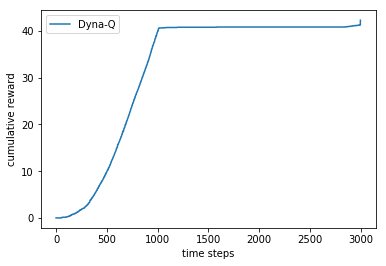

In [12]:
visualize()

# Experiments

# How dows Dyna-Q relate to Experience Replay ?

# Conclusion